# Kaggle - Mpred
## Predicitive Maintenance Challenge
### https://www.kaggle.com/c/mpred-datascience-challenge
#### By: 55thSwiss


## Introduction

"A major problem faced by businesses in asset-heavy industries such as manufacturing is the significant 
costs that are associated with delays in the production process due to mechanical problems. Most of these 
businesses are interested in predicting these problems in advance so that they can proactively prevent the 
problems before they occur which will reduce the costly impact caused by downtime.

The business problem for this example is about predicting problems caused by component failures such that 
the question “What is the probability that a machine will fail in the near future due to a failure of a 
certain component” can be answered. The problem is formatted as a multi-class classification problem and 
a machine learning algorithm is used to create the predictive model that learns from historical data collected 
from machines.

The goal is to predict when a given machine will fail within 24 hours due to a failure of a given component."

## Sources

The Azure AI Guide for Predictive Maintenance Solutions [1]  was a tremendous resource in order to wrap my head around the many aspects and challenges of predictive maintenance. There are also some good training resouce links at the end. 

Original data set used in this exercise can be found at [2]

Although this data has already been collected and it's only an exercise (so there are no subject matter experts or a collaborative team to consult) the practices employed will still represent the CRISP-DM philosophy as much as possible [3].

The 'Modelling Guide For Predictive Maintenance' was a critical resource in learning how to deal with time windows in ML [4]

Scikit-Learn is the only modelling resource that will be used in this exercise, here is the documentation for categorical supervised learning models [5].

[1] https://docs.microsoft.com/fr-fr/azure/machine-learning/team-data-science-process/cortana-analytics-playbook-predictive-maintenance

[2] https://www.kaggle.com/yuansaijie0604/xinjiang-pm/data

[3] https://en.wikipedia.org/wiki/Cross-industry_standard_process_for_data_mining

[4] https://gallery.azure.ai/Collection/Predictive-Maintenance-Implementation-Guide-1

[5] https://scikit-learn.org/stable/supervised_learning.html#supervised-learning

## Problem Description

In this competition, the goal is to compute the probability that a machine will fail in 
the next 24 hours due to a specific component failure (component 1,2,3 or 4) hence you are asked to classify the 
observations into 5 categories : comp1, comp2,comp3,comp4 and none (e.g : The machine will fail due to 
component 1... 4 or will not fail in the next 24h). From a machine learning perspective this is called a multi-class classification problem.

## Data File Descriptions

__telemetry.csv__ The first data source is the telemetry time-series data which consists of voltage, rotation, pressure and vibration measurements collected from 100 machines in real time averaged over every hour collected during the year 2015

__errors.csv__ The errors logs are non-breaking errors thrown while the machine is still operational and do not constitute as failures. The error date and times are rounded to the closest hour since the telemetry data is collected at an hourly rate.

__maint.csv__ This file contains the scheduled and unscheduled maintenance records which correspond to both regular inspection of components as well as failures. A record is generated if a component is replaced either during the scheduled inspection or due to a break down. The records that are created due to break downs will be called failures which is explained in the later sections. Maintenance data has both 2014 and 2015 records.

__machines.csv__ This data set includes some information about the machines which are model type and years in service.

__failures.csv__ These are the records of component replacements due to failures. Each record has a date and time, machine ID and failed component type.

## Data fields

__volt, rotate, pressure, vibration__ Hourly voltage, rotation, pressure and vibration measurements collected from the machines

__machineID__ The ID of a machine

__datetime__ Time stamp of the entry

__errorID__ The ID of an error

__comp__ The component replaced during the scheduled maintenance

__model__ Model number of the machine

__age__ Years in service

__errorID__ The ID of an error

__failure__ Failed component type

## Train / Split Requirements

The training set will contain the data of 70 machines while the test set will contain the data of the 30 remaining machines

The data is collected every hour for a year. For simplicity, you are asked to group the data into 3 hours windows.

## Getting Started:

### First Assessment
There has been a problem defined that forms the objective of the project and we've also been given the data to work with. Typically this would be steps one __(1.)__ and two __(2.)__ respectively in a machine learning / data analysis problem, gaining an understanding of the business and defining the problem to be solved (a precursor to deciding requirements and method of solution) as well determining sources and gathering the raw data.

### 3. Wrangling
There are a few requirements from the introduction on the formatting of the data and how it should be proceesed. In this step the data will be examined for it's architecture in regards to storage and processing, and an initial cleaning for aberrant, missing, duplicate, or outlier data points within each dataset. This is a good point to determine possible independent and dependent variables.  If a key feature has been identified, the dataframes will be easily concatenated, otherwise it will be done "manually". Lastly, the cumulative dataframe can be split into training, test, and validation tables. 

In [127]:
#library dependencies
import sys
import os
import pandas as pd 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.ticker as ticker
import seaborn as sns
import sklearn
from sklearn.preprocessing import minmax_scale
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import datetime
from datetime import date
import warnings
warnings.filterwarnings('ignore')


#vizualization defaults
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


The first dataset I tried looking at was telemetry.csv, but an error kicked up when loading the CSV:

```ParserError: Error tokenizing data. C error: Expected 6 fields in line 92490, saw 9```

This likely came from missing information, meaning cells that were void of any value or had a strange format to them. Opening in a spreadsheet editor like Excel often fixes this by replacing the empty cells with a NaN status. 

In [128]:
#import data
sensorData = pd.read_csv('PdM_telemetry.csv')
maintenanceData = pd.read_csv('PdM_maint.csv')
originsData = pd.read_csv('PdM_machines.csv')
failureData = pd.read_csv('PdM_failures.csv')
errorData = pd.read_csv('PdM_errors.csv')

We'll do a first run through starting with 'telemetry.csv' since this is the largest dataset. After opening the csv in Excel we're able to import it into the notebook but it has three columns of entirely null values. I've confirmed this is just an anomaly and the csv is infact empty in those columns (seems to be a formatting error, one row contained a shifted column heading in the data cells), they will be dropped. 

#### Telemetry Data:

This is is going to be the most valuable dataset inidivudally, as it contains a vast amount of sensor readings from one hundred different machines. This will probably be the foundation dataset for merging.

In [129]:
#first look
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 968589 entries, 0 to 968588
Data columns (total 9 columns):
datetime      968589 non-null object
machineID     968589 non-null int64
volt          968589 non-null float64
rotate        968589 non-null object
pressure      968589 non-null object
vibration     968589 non-null object
Unnamed: 6    1 non-null object
Unnamed: 7    1 non-null object
Unnamed: 8    1 non-null object
dtypes: float64(1), int64(1), object(7)
memory usage: 66.5+ MB


In [130]:
sensorData.sample(3)

,datetime,machineID,volt,rotate,pressure,vibration,Unnamed: 6,Unnamed: 7,Unnamed: 8
603157,4/16/2015 16:00,59,155.909256,490.661,83.8678,40.7117,NaN,NaN,NaN
684578,8/1/2015 20:00,68,166.801167,405.74,105.283,38.9913,NaN,NaN,NaN
54770,4/3/2015 2:00,7,161.938889,363.319,97.1523,41.0442,NaN,NaN,NaN


In [131]:
# row index 92488 was the problem from above, drop the row and clean up columns
# drop row 92488
sensorData.drop(92488, inplace = True)
# drop the empty data columns
sensorData.drop(['Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8'], axis=1, inplace=True)
# convert the column 'datetime' to pandas datetime datatype using the infer arguement to find the fastest method for parsing
sensorData['datetime'] = pd.to_datetime(sensorData['datetime'], infer_datetime_format = True)

# Volt was already assigned as a float, change the datatype of 'rotate', 'pressure', and 'vibration' to match
sensorData['rotate'] = sensorData['rotate'].astype(float)
sensorData['pressure'] = sensorData['pressure'].astype(float)
sensorData['vibration'] = sensorData['vibration'].astype(float)

# check the adjusted datatypes
sensorData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 968588 entries, 0 to 968588
Data columns (total 6 columns):
datetime     968588 non-null datetime64[ns]
machineID    968588 non-null int64
volt         968588 non-null float64
rotate       968588 non-null float64
pressure     968588 non-null float64
vibration    968588 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 51.7 MB


In [132]:
# check out some statistics on the dataset (size, means, standard deviations, mins, quartiles, and maxes)
sensorData.describe()

,machineID,volt,rotate,pressure,vibration
count,968588.000000,968588.000000,968588.000000,968588.000000,968588.000000
mean,46.230764,170.774119,446.591205,100.841515,40.383648
std,30.450409,15.507488,52.701718,11.028763,5.366198
min,1.000000,97.333604,138.432075,51.237106,14.877054
25%,18.000000,160.298184,412.278255,93.492369,36.778303
50%,45.000000,170.597611,447.555368,100.414332,40.237433
75%,73.000000,181.006196,482.154486,107.535244,43.781329
max,100.000000,255.124717,695.020984,185.951998,76.791072


It looks like every feature has data points that are well outside three standard deviations of their respective mean. The outliers need to be looked at and dealt with if they're determined to be noise in the dataset, although these could be triggers corresponding to the failure mode in so they won't be removed just yet.

In [133]:
# organizing the data by date
sensorData.sort_values(by=['datetime'], inplace = True)

In [134]:
# look at an example, machine 1
mask = sensorData['machineID'] == 1
sensorData[mask].head(5)

,datetime,machineID,volt,rotate,pressure,vibration
0,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92489,2015-01-01 06:00:00,1,176.217853,418.504078,113.077935,45.087686
92490,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
1,2015-01-01 07:00:00,1,162.879223,402.747490,95.460525,43.413973
2,2015-01-01 08:00:00,1,170.989902,527.349825,75.237905,34.178847


In [135]:
# looking at the results above, their appears to be duplicated data based on the 'datetime' feature, checking the sensor
    # readings next it looks obvious these are just dublicated rows. Investigate a litte here:
sum(sensorData[mask].duplicated('datetime'))

8761

In [136]:
# cleaning the duplicate data and check

# for some reason using all the telemetry feature names resulted in an error. Just using Volt gives the desired result though
sensorData.drop_duplicates(subset=['datetime', 'machineID', 'volt'], inplace = True)
# check for duplicates
sum(sensorData[mask].duplicated('datetime'))

0

In [137]:
# check a 24 hour period of another machine for consistancy, machine 2
mask = sensorData['machineID'] == 2
sensorData[mask].head(24)

,datetime,machineID,volt,rotate,pressure,vibration
8761,2015-01-01 06:00:00,2,176.558913,424.624162,76.005332,43.767049
8762,2015-01-01 07:00:00,2,158.282044,432.372960,110.907806,37.267114
101252,2015-01-01 08:00:00,2,168.242028,454.629639,97.877007,39.709461
101253,2015-01-01 09:00:00,2,180.280316,438.391022,84.440430,40.490443
101254,2015-01-01 10:00:00,2,169.719531,473.055664,110.395683,41.229578
101255,2015-01-01 11:00:00,2,191.257247,369.738792,101.223451,45.616543
8767,2015-01-01 12:00:00,2,186.282977,483.698416,115.061863,50.690561
101257,2015-01-01 13:00:00,2,179.367188,450.943961,94.378019,38.684815
101258,2015-01-01 14:00:00,2,168.893782,494.876313,101.910022,34.566681
101259,2015-01-01 15:00:00,2,158.595797,427.282619,92.470163,32.160232


In [138]:
# organize the dataframe by 'machineID' first, then 'datetime' for easier reading
sensorData.sort_values(['machineID', 'datetime'], inplace = True)

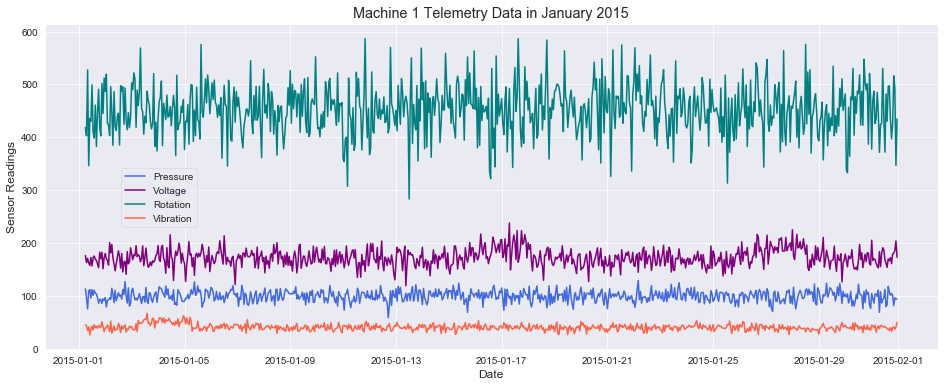

In [139]:
# plotting the first month of 'pressure' data from machine 1 for visualization, it should be noted the sensor values
    # have not been normalized to one another hence the scale difference
plt_df = sensorData.loc[(sensorData['machineID'] == 1) & 
                         (sensorData['datetime'] > pd.to_datetime('2014-12-31')) & 
                         (sensorData['datetime'] < pd.to_datetime('2015-02-01')), ['datetime', 'pressure', 'volt', 'rotate', 'vibration']]
sns.set_style("darkgrid")
plt.figure(figsize=(16, 6))
plt.plot(plt_df['datetime'], plt_df['pressure'], color = 'royalblue', label = 'Pressure')
plt.plot(plt_df['datetime'], plt_df['volt'], color = 'purple', label = 'Voltage')
plt.plot(plt_df['datetime'], plt_df['rotate'], color = 'teal', label = 'Rotation')
plt.plot(plt_df['datetime'], plt_df['vibration'], color = 'tomato', label = 'Vibration')
plt.ylabel('Sensor Readings')
plt.xlabel('Date')
plt.title('Machine 1 Telemetry Data in January 2015')
plt.legend(bbox_to_anchor=(.08, .36))
#plt.legend()

Telemetry sensor data looks clean enough for the first pass, there are no missing values, the features have been converted to appropriate data types, and a quick visualization shows no extreme outliers in the data set.

#### Maintenance Data

This csv contains components that were changed due to scheduled maintenance and failures. At the same time, the failures are logged in a separate dataset, which will likely be more pertinent to our model. After cleaning all the datasets we can compare the scheduled changes and failures to the failure data csv and check for duplication, completeness, etc.

In [140]:
# convert the column 'datetime' to pandas datetime datatype using the infer arguement to find the fastest method for parsing
maintenanceData['datetime'] = pd.to_datetime(maintenanceData['datetime'], infer_datetime_format = True)
# convert the 'component' column to a categorical datatype
maintenanceData['comp'] = maintenanceData['comp'].astype('category')
# check
maintenanceData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3286 entries, 0 to 3285
Data columns (total 3 columns):
datetime     3286 non-null datetime64[ns]
machineID    3286 non-null int64
comp         3286 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 54.8 KB


In [141]:
# take a look at some data
maintenanceData.sample(5)

,datetime,machineID,comp
1476,2015-04-22 06:00:00,45,comp1
3078,2015-11-04 06:00:00,94,comp3
1240,2015-04-17 06:00:00,38,comp4
2876,2015-03-20 06:00:00,88,comp1
897,2014-09-29 06:00:00,28,comp2


In [142]:
# remove the begnning characters from 'comp' column the datatype to an integer
maintenanceData['comp'] = maintenanceData['comp'].str[4:].astype(int)
maintenanceData.sample(3)

,datetime,machineID,comp
2443,2015-01-22 06:00:00,75,1
392,2015-07-06 06:00:00,12,1
3146,2015-10-15 06:00:00,96,1


In [143]:
# check for duplicated rows by 'datetime', 'machineID', and 'comp' 
maintenanceData.duplicated(['datetime', 'machineID', 'comp']).sum()

0

In [144]:
# create new columns with a binary identifier for component changes to assess if more than one
    # component was changed on the same machine at the same time
maintenanceData = pd.concat([maintenanceData, pd.get_dummies(maintenanceData.comp)], 1).groupby(['datetime','machineID']).sum().reset_index()

In [145]:
# drop the original 'comp' column
maintenanceData.drop(['comp'], axis=1, inplace=True)
# rename the columns
maintenanceData.columns = ['datetime', 'machineID', 'mComp_1', 'mComp_2', 'mComp_3', 'mComp_4']
maintenanceData.sample(3)

,datetime,machineID,mComp_1,mComp_2,mComp_3,mComp_4
2218,2015-11-12 06:00:00,93,0,1,1,0
1609,2015-08-01 06:00:00,76,1,1,0,0
835,2015-03-29 06:00:00,53,1,0,0,0


In [146]:
# check that the concatenation worked and get_dummies columns has multiple entries for different components
    # under the same 'datetime' and 'machineID'
print(((maintenanceData['mComp_1'] == 1) & (maintenanceData['mComp_2'] == 1)).any())
# check for duplicates in 'datetime' and 'machineID', there should be none
print(maintenanceData.duplicated(['datetime', 'machineID']).sum())

True
0


Text(0.5, 0, 'Components')

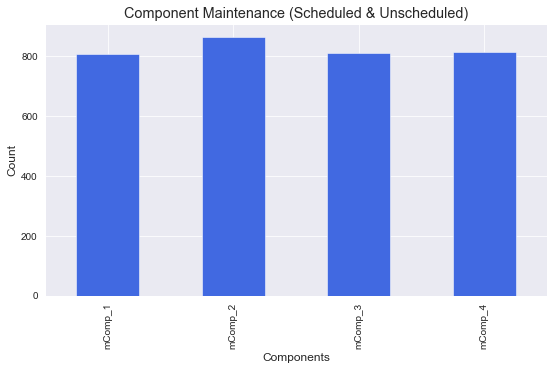

In [147]:
# graph the sums of individual component maintenance
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
maintenanceData.sum().reindex(index = ['mComp_1', 'mComp_2', 'mComp_3', 'mComp_4'], axis = 1).plot(kind = 'bar', color = 'royalblue').set_title('Component Maintenance (Scheduled & Unscheduled)')
plt.ylabel('Count')
plt.xlabel('Components')

#### Origins Data

The vintage of each machine should add valuable correlation to the frequency of scheduled and failure component repairs.

In [148]:
# change the 'model' column to categorical
originsData['model'] = originsData['model'].astype('category')
# check if the data is uniform
originsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 3 columns):
machineID    100 non-null int64
model        100 non-null category
age          100 non-null int64
dtypes: category(1), int64(2)
memory usage: 1.9 KB


In [149]:
# remove the begnning characters from 'model' column
originsData['model'] = originsData['model'].str[5:]

In [150]:
# check some statistics on the age of the machinery
originsData['age'].describe()

count    100.000000
mean      11.330000
std        5.856974
min        0.000000
25%        6.750000
50%       12.000000
75%       16.000000
max       20.000000
Name: age, dtype: float64

In [151]:
# view sample data
originsData.sample(3)

,machineID,model,age
85,86,3,2
8,9,4,7
40,41,4,9


Text(0.5, 0, 'Model')

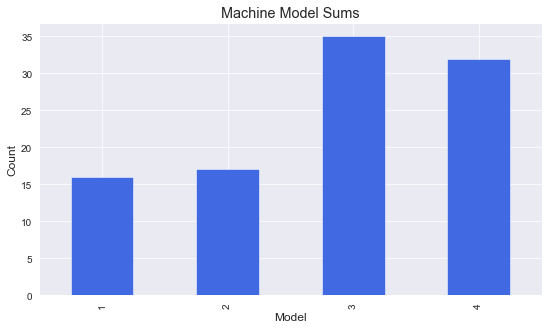

In [152]:
# quantity of each model
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
originsData.model.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Machine Model Sums')
plt.ylabel('Count')
plt.xlabel('Model')

Text(0.5, 0, 'Age')

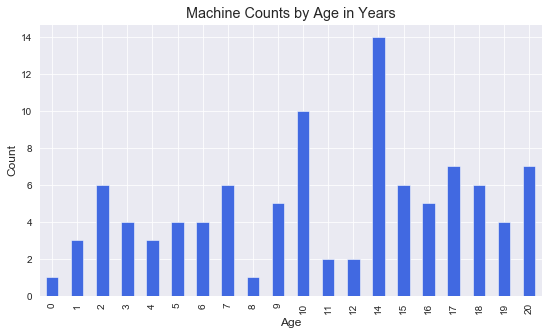

In [153]:
# quantity of each vintage
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
originsData.age.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Machine Counts by Age in Years')
plt.ylabel('Count')
plt.xlabel('Age')

#### Failure Data

This dataset contains critical features to predicting future failures.

In [154]:
# convert the column 'datetime' to pandas datetime datatype using the infer arguement to find the fastest method for parsing
failureData['datetime'] = pd.to_datetime(failureData['datetime'], infer_datetime_format = True)
# change the 'failure' column to categorical
failureData['failure'] = failureData['failure'].astype('category')
# check for uniformity
failureData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 761 entries, 0 to 760
Data columns (total 3 columns):
datetime     761 non-null datetime64[ns]
machineID    761 non-null int64
failure      761 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 12.9 KB


In [155]:
# remove the begnning characters from 'failure' column
failureData['failure'] = failureData['failure'].str[4:]
failureData.sample(3)

,datetime,machineID,failure
353,2015-07-10 06:00:00,48,2
531,2015-08-30 06:00:00,73,3
750,2015-07-02 06:00:00,99,2


In [156]:
# check for duplicated rows by 'datetime', 'machineID', and 'failure' 
failureData.duplicated(['datetime', 'machineID', 'failure']).sum()

0

Text(0.5, 0, 'Component')

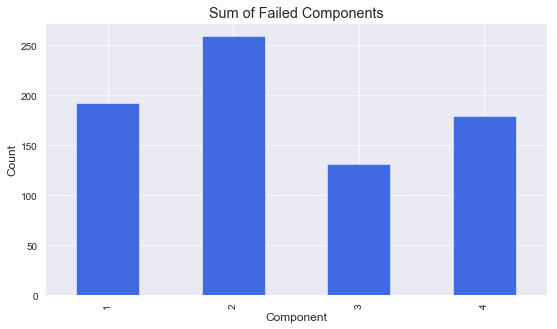

In [157]:
# quantity of each failure
sns.set_style("darkgrid")
plt.figure(figsize=(9, 5))
failureData.failure.value_counts().sort_index().plot(kind = 'bar', color = 'royalblue').set_title('Sum of Failed Components')
plt.ylabel('Count')
plt.xlabel('Component')

#### Error Data

We're going to see if there is a correlation between the errors generated on the machines, and eventual component maintenance / failure.

In [158]:
# convert the column 'datetime' to pandas datetime datatype using the infer arguement to find the fastest method for parsing
errorData['datetime'] = pd.to_datetime(errorData['datetime'], infer_datetime_format = True)
# change the 'errorID' column to categorical
errorData['errorID'] = errorData['errorID'].astype('category')
errorData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3919 entries, 0 to 3918
Data columns (total 3 columns):
datetime     3919 non-null datetime64[ns]
machineID    3919 non-null int64
errorID      3919 non-null category
dtypes: category(1), datetime64[ns](1), int64(1)
memory usage: 65.3 KB


In [159]:
# remove the begnning characters from 'errorID' column
errorData['errorID'] = errorData['errorID'].str[5:]

In [160]:
errorData.head(3)

,datetime,machineID,errorID
0,2015-01-03 07:00:00,1,1
1,2015-01-03 20:00:00,1,3
2,2015-01-04 06:00:00,1,5


In [161]:
# check for duplicated rows by 'datetime', 'machineID', and 'errorID' 
errorData.duplicated(['datetime', 'machineID', 'errorID']).sum()

0

In [162]:
# create new columns with a binary identifier for machine errors to assess if more than one
    # error was generated on the same machine at the same time
errorData = pd.concat([errorData, pd.get_dummies(errorData.errorID)], 1).groupby(['datetime','machineID']).sum().reset_index()

In [163]:
# rename the columns
errorData.columns = ['datetime', 'machineID', 'error_1', 'error_2', 'error_3', 'error_4', 'error_5']
# their are five different error alarms that could be generated, not to be confused with the four possible component failures
mask = errorData['machineID'] == 1
errorData[mask].head(5)
#errorData.head(3)

,datetime,machineID,error_1,error_2,error_3,error_4,error_5
26,2015-01-03 07:00:00,1,1,0,0,0,0
30,2015-01-03 20:00:00,1,0,0,1,0,0
38,2015-01-04 06:00:00,1,0,0,0,0,1
103,2015-01-10 15:00:00,1,0,0,0,1,0
227,2015-01-22 10:00:00,1,0,0,0,1,0


In [164]:
# check that the concatenation worked and get_dummies columns has multiple entries for different errors
    # under the same 'datetime' and 'machineID'
print(((errorData['error_1'] == 1) & (errorData['error_2'] == 1)).any())
# check for duplicates in 'datetime' and 'machineID', there should be none
print(errorData.duplicated(['datetime', 'machineID']).sum())

True
0


Text(0.5, 0, 'Error')

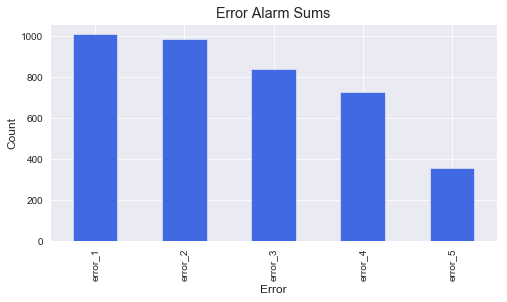

In [165]:
sns.set_style("darkgrid")
plt.figure(figsize=(8, 4))
errorData.sum().reindex(index = ['error_1', 'error_2', 'error_3', 'error_4', 'error_5'], axis = 1).plot(kind = 'bar', color = 'royalblue').set_title('Error Alarm Sums')
plt.ylabel('Count')
plt.xlabel('Error')

### 4. Feature Engineering, Label Construction, Merging, and Final Cleaning



#### Sensor Lag Windows
In the following, a rolling lag window is created for the sensor data based on a three hour window per the requirements in 'Train / Split'. In order to create a lag window, the data must be supplied with a time stamp. Generally, sensor data is, which makes it easy to create these windows. The lag windows create a summary that we can view statistics on like mean, standard deviation, minimums, maximums, etc.

In [166]:
# telemetry means lag window

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
    # append to the list 'temp' a three hour (3H) sample taking the mean for each 'column' from the 'features' list
    temp.append(pd.pivot_table(sensorData, index = 'datetime', columns = 'machineID', values = column)
                .resample('3H', closed = 'left', how = 'mean', label = 'right').unstack())
# create a dataframe to hold the information and concat the 'temp' list
sensorData3H_mean = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '3H_mean'
sensorData3H_mean.columns = [n + '3H_mean' for n in features]
# reset the index values
sensorData3H_mean.reset_index(inplace = True)


# telemetry standard deviation lag window

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['volt', 'rotate', 'pressure', 'vibration']
# loop
for column in features:
    # append to the list 'temp' a three hour (3H) sample taking the standard deviation for each 'column' from the 'features' list
    temp.append(pd.pivot_table(sensorData, index = 'datetime', columns = 'machineID', values = column)
                .resample('3H', how = 'std', closed = 'left', label = 'right').unstack())
# create a dataframe to hold the information and concat the 'temp' list
sensorData3H_std = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '3H_std'
sensorData3H_std.columns = [n + '3H_std' for n in features]
# reset the index values
sensorData3H_std.reset_index(inplace = True)

In [167]:
# check for three hour increments
sensorData3H_mean.head(3)

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405


In [168]:
# check for three hour increments
sensorData3H_std.head(3)

,machineID,datetime,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std
0,1,2015-01-01 09:00:00,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,10.124584,55.084734,5.909721,5.169304


In [169]:
# merge the new features into one df
sensorLagWindow = pd.merge(sensorData3H_mean, sensorData3H_std, on = ['datetime', 'machineID']).dropna()
# index according to 'machineID' and 'datetime'
sensorLagWindow.groupby(['machineID', 'datetime']).sum().reset_index()
# check
sensorLagWindow.head(3)

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304


#### Error Lag Window
The errors data set also contains time stamps, so we can create a similar lag window for the errors. The notable difference is we want to sum the rows for each window as opposed to averaging.

In [170]:
# error sum lag window

# create an empty list 'temp'
temp = [] 
# define the feature columns to be iterated
features = ['error_1', 'error_2', 'error_3', 'error_4', 'error_5']
# loop
for column in features:
    # append to the list 'temp' a three hour (3H) sample taking the sum for each 'column' from the 'features' list
    temp.append(pd.pivot_table(errorData, index = 'datetime', columns = 'machineID', values = column)
                .resample('3H', closed = 'left', how = 'sum', label = 'right').unstack())
# create a dataframe to hold the information and concat the 'temp' list
errorLagWindow = pd.concat(temp, axis = 1)
# name the columns using the list 'features' + '3H_sum
errorLagWindow.columns = [n + '_3H_sum' for n in features]
# reset the index values
errorLagWindow.reset_index(inplace = True)

In [171]:
# check that at least one column contains more than a '1', and that at least two columns have a 
    # '1' at the same time, indicating the resample likely worked
print((errorLagWindow['error_1_3H_sum'] == 2).any())
print(((errorLagWindow['error_1_3H_sum'] == 1) & (errorLagWindow['error_2_3H_sum'] == 1)).any())

True
True


In [172]:
errorLagWindow.head(3)

,machineID,datetime,error_1_3H_sum,error_2_3H_sum,error_3_3H_sum,error_4_3H_sum,error_5_3H_sum
0,1,2015-01-01 09:00:00,0.0,0.0,0.0,0.0,0.0
1,1,2015-01-01 12:00:00,0.0,0.0,0.0,0.0,0.0
2,1,2015-01-01 15:00:00,0.0,0.0,0.0,0.0,0.0


#### Running 'Days Since Replacement'
The maintenance data set in this problem should possess critical informaiton towards predicting component failures. Considering we're trying to predict a future failure, a feature that tracked how long it's been since maintenance was last performed on that component would be valuable.

In [173]:
# create a column for each error type
runningComps = pd.get_dummies(maintenanceData.set_index('datetime')).reset_index()
runningComps.columns = ['datetime', 'machineID', 'rComp_1', 'rComp_2', 'rComp_3', 'rComp_4']

# sort by 'machineID' and 'datetime' to combine repairs made on a single machine into a one hour window
runningComps = runningComps.groupby(['machineID', 'datetime']).sum().reset_index()

# fill out the hourly windows where no components were replaced by using the 'sensorData' set's 'datetime' and 'machineID'
    # columns because they're complete, then filling the empty new rows with '0', and last
    # sorting by 'machineID' and 'datetime'
runningComps = sensorData[['datetime', 'machineID']].merge(runningComps,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

# drop the first four rows containing dates from 2014, these are also not in the telemetry dataset and so cannot
    # be filled in appropriately
runningComps.drop(runningComps.index[0:4], inplace = True)
# alternate method of dropping based on date:
# compFeatures = compFeatures.loc[compFeatures['datetime'] > pd.to_datetime('2015-01-01')]

components = ['rComp_1', 'rComp_2', 'rComp_3', 'rComp_4']
for comp in components:
    # convert indicator to most recent date of component change
    runningComps.loc[runningComps[comp] < 1, comp] = None
    runningComps.loc[-runningComps[comp].isnull(), comp] = runningComps.loc[-runningComps[comp].isnull(), 'datetime']

    # forward-fill the most-recent date of component change
    runningComps[comp] = runningComps[comp].fillna(method='ffill')

# convert 'datetime' column from np to standard? not having this line was a huge problem
runningComps['datetime'] = pd.to_datetime(runningComps['datetime'], infer_datetime_format = True)
# replace dates of most recent component change with days since most recent component change
for comp in components:
    runningComps[comp] = pd.to_datetime(runningComps[comp], infer_datetime_format = True)
    runningComps[comp] = (runningComps['datetime'] - runningComps[comp]) / np.timedelta64(1, 'D')

In [174]:
runningComps.describe()

,machineID,rComp_1,rComp_2,rComp_3,rComp_4
count,876461.000000,876365.000000,873845.000000,876005.000000,876365.000000
mean,50.499813,53.439534,50.816212,52.589533,53.742743
std,28.865802,62.860983,58.461326,59.185057,60.035025
min,1.000000,-578.000000,-578.000000,-579.000000,-577.000000
25%,26.000000,13.291667,12.083333,13.083333,13.000000
50%,50.000000,32.791667,29.541667,32.250000,32.500000
75%,75.000000,68.708333,66.000000,67.250000,70.416667
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [175]:
runningComps.tail()

,datetime,machineID,rComp_1,rComp_2,rComp_3,rComp_4
876095,2016-01-01 02:00:00,100,82.833333,7.833333,82.833333,52.833333
876096,2016-01-01 03:00:00,100,82.875000,7.875000,82.875000,52.875000
876097,2016-01-01 04:00:00,100,82.916667,7.916667,82.916667,52.916667
876098,2016-01-01 05:00:00,100,82.958333,7.958333,82.958333,52.958333
876099,2016-01-01 06:00:00,100,83.000000,8.000000,83.000000,53.000000


#### Merger

In [176]:
# combine all the engineered features into one matrix
final_features = sensorLagWindow.merge(errorLagWindow, on = ['datetime', 'machineID'], how = 'left')
final_features = final_features.merge(runningComps, on = ['datetime', 'machineID'], how = 'left')
final_features = final_features.merge(originsData, on = ['machineID'], how = 'left')

# descriptive statistics
final_features.describe()

,machineID,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std,error_1_3H_sum,error_2_3H_sum,error_3_3H_sum,error_4_3H_sum,error_5_3H_sum,rComp_1,rComp_2,rComp_3,rComp_4,age
count,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,292000.000000,291969.000000,291129.000000,291849.000000,291969.000000,292000.000000
mean,50.500000,170.777300,446.605807,100.858510,40.384920,13.299090,44.456338,8.885976,4.441164,0.003459,0.003384,0.002870,0.002490,0.001219,53.467920,50.826573,52.603146,53.756621,11.330000
std,28.866119,9.500846,33.130042,7.414517,3.478823,6.965914,23.216712,4.656211,2.320302,0.058769,0.058070,0.053494,0.049835,0.034895,62.482015,58.111238,58.817849,59.683667,5.827625
min,1.000000,125.532506,211.811184,72.118639,26.569635,0.025509,0.078991,0.027417,0.015278,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,164.449510,427.560977,96.238546,38.147765,8.027455,26.903705,5.370581,2.684790,0.000000,0.000000,0.000000,0.000000,0.000000,13.250000,12.000000,13.125000,13.000000,6.750000
50%,50.500000,170.434378,448.382261,100.234191,40.145837,12.495658,41.794719,8.346020,4.173955,0.000000,0.000000,0.000000,0.000000,0.000000,32.750000,29.500000,32.250000,32.500000,12.000000
75%,75.250000,176.611778,468.448505,104.406557,42.227559,17.688490,59.104130,11.790303,5.900106,0.000000,0.000000,0.000000,0.000000,0.000000,68.625000,65.875000,67.125000,70.375000,16.000000
max,100.000000,241.420717,586.682904,162.309656,69.311324,58.444332,179.903039,35.659369,18.305595,2.000000,1.000000,1.000000,1.000000,1.000000,491.875000,348.875000,370.875000,394.875000,20.000000


In [177]:
# take a look
final_features.head()

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std,error_1_3H_sum,error_2_3H_sum,error_3_3H_sum,error_4_3H_sum,error_5_3H_sum,rComp_1,rComp_2,rComp_3,rComp_4,model,age
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3,18
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3,18
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3,18
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3,18
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,3,18


#### Label Selection

Here we want to take a period of time before a component failure and label those feature records as "about to fail" while labelling the other records as "normal". An important decision must be made as to an appropriate window, which will depend on the business case. For this example we're using a twenty four hour failure period, but it's possible a replacement part or employee scheduling may require more notification than that.

A new feature titled "failure" is created below. These will be labelled according to the component that failed over the previous twenty four hours of that failure. For instance, "failure = component_1" or "component_2". All other rows will be labelled "failure = none".

In [178]:
# merge the failures dataset with the engineered features
labeled_features = final_features.merge(failureData, on = ['datetime', 'machineID'], how='left')
# backfill the failure column with the last known failed component for a twenty four hour period
    # limit = 7 : ((24 hours / 3 hour lag window) - 1 for the last know component variable)
labeled_features = labeled_features.fillna(method = 'bfill', limit = 7) 
# fill all other failure columns not containing a component variable with '0'
labeled_features = labeled_features.fillna(0)
# change the 'failure' and 'model' feature back to categorical. They were, do not see why this changed??
labeled_features[['failure', 'model']] = labeled_features[['failure', 'model']].astype('category')
labeled_features['failure'] = labeled_features['failure'].astype(int)
# check
labeled_features.head()

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std,error_1_3H_sum,error_2_3H_sum,error_3_3H_sum,error_4_3H_sum,error_5_3H_sum,rComp_1,rComp_2,rComp_3,rComp_4,model,age,failure
0,1,2015-01-01 09:00:00,170.028993,449.533798,94.592122,40.893502,6.721032,67.849599,18.934956,5.874970,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,18,0
1,1,2015-01-01 12:00:00,164.192565,403.949857,105.687417,34.255891,7.596570,50.120452,8.555032,7.662229,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,18,0
2,1,2015-01-01 15:00:00,168.134445,435.781707,107.793709,41.239405,10.124584,55.084734,5.909721,5.169304,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,18,0
3,1,2015-01-01 18:00:00,165.514453,430.472823,101.703289,40.373739,4.673269,42.047278,4.554047,2.106108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,18,0
4,1,2015-01-01 21:00:00,168.809347,437.111120,90.911060,41.738542,14.752132,47.048609,4.244158,2.207884,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,18,0


Below are two examples where 'component 1' has failed. Notice the consecutive index values and the 'datetime' feature, eight rows together equal the twenty four hour window. After the eighth row a new time period starts for the next time 'component 1' failed.

In [179]:
labeled_features.loc[labeled_features['failure'] == 1][:16]

,machineID,datetime,volt3H_mean,rotate3H_mean,pressure3H_mean,vibration3H_mean,volt3H_std,rotate3H_std,pressure3H_std,vibration3H_std,error_1_3H_sum,error_2_3H_sum,error_3_3H_sum,error_4_3H_sum,error_5_3H_sum,rComp_1,rComp_2,rComp_3,rComp_4,model,age,failure
504,1,2015-03-05 09:00:00,187.866142,419.978727,89.164859,39.214537,19.004215,51.227739,14.654356,6.046484,1.0,0.0,0.0,0.0,0.0,44.125,0.000,14.125,29.125,3,18,1
505,1,2015-03-05 12:00:00,193.007454,476.652609,93.764296,44.146023,30.172454,9.977326,10.238886,3.807972,0.0,0.0,0.0,0.0,0.0,44.250,0.000,14.250,29.250,3,18,1
506,1,2015-03-05 15:00:00,184.857750,394.936867,98.434207,40.865686,3.970792,52.886285,8.426741,6.269036,0.0,0.0,0.0,0.0,0.0,44.375,0.000,14.375,29.375,3,18,1
507,1,2015-03-05 18:00:00,201.233755,432.123974,103.184245,38.960594,13.880938,51.134599,10.538912,6.323125,0.0,0.0,0.0,0.0,0.0,44.500,0.000,14.500,29.500,3,18,1
508,1,2015-03-05 21:00:00,188.591518,445.387172,107.938717,38.102727,20.488049,28.547877,6.607310,7.793241,0.0,0.0,0.0,0.0,0.0,44.625,0.000,14.625,29.625,3,18,1
509,1,2015-03-06 00:00:00,188.921174,452.048345,103.282805,39.639146,12.492237,67.686796,13.792230,8.259911,0.0,0.0,0.0,0.0,0.0,44.750,0.000,14.750,29.750,3,18,1
510,1,2015-03-06 03:00:00,176.407356,439.768139,99.823574,40.008122,16.116969,61.562327,12.578309,6.903479,0.0,0.0,0.0,0.0,0.0,44.875,0.000,14.875,29.875,3,18,1
511,1,2015-03-06 06:00:00,163.638876,467.391175,94.660949,38.667932,5.792593,53.901669,6.249948,7.661121,0.0,0.0,0.0,0.0,0.0,0.000,0.000,15.000,30.000,3,18,1
3528,2,2015-03-18 09:00:00,175.471523,382.521159,93.885594,38.319541,11.463899,86.527935,4.701340,3.113038,1.0,1.0,1.0,0.0,0.0,275.125,215.125,29.125,14.125,4,7,1
3529,2,2015-03-18 12:00:00,205.271773,340.915117,101.364846,43.819837,8.929564,12.264776,1.921422,1.196788,0.0,0.0,0.0,0.0,0.0,275.250,215.250,29.250,14.250,4,7,1


In [180]:
# scikit-learn primarily uses NumPy arrays, make sure ther are no object datatypes (Python strings)
labeled_features.dtypes

machineID                    int64
datetime            datetime64[ns]
volt3H_mean                float64
rotate3H_mean              float64
pressure3H_mean            float64
vibration3H_mean           float64
volt3H_std                 float64
rotate3H_std               float64
pressure3H_std             float64
vibration3H_std            float64
error_1_3H_sum             float64
error_2_3H_sum             float64
error_3_3H_sum             float64
error_4_3H_sum             float64
error_5_3H_sum             float64
rComp_1                    float64
rComp_2                    float64
rComp_3                    float64
rComp_4                    float64
model                     category
age                          int64
failure                      int32
dtype: object

### 5. Modelling

#### Train/Test Split and Analysis

As with all machine learning models, over fitting the model to the training data will have a negative impact on the model's performance in the real world. This may be even more important in the case of time stamped and grouped data (like in this case with Lag Windows) where any possible overlap or break in these windows will certainly cause the model to perform poorly. Due to this reason, time based data should be carefully partitioned into large chunks to avoid any overlap or destruction of a proper window.

It makes sense to consider trends on manufacturing equipment in regards to a time series data. Machines have a constant degradation factor and although a single component can be replaced, a machine's overall health will deteriorate with time. To keep this in mind, the older records should be used for training purposes and the newer records for testing and validation, this will allow the model to mitigate some of the error due to overall machine condition due to age because newer sensor readings should provide a slightly worse threshold overall. 

To consider all this, the data will be split into three partitions for taining, testing, and validating. After the split point is decided, a window of data should be discarded at that location to prevent the above problems. 

##### Train/Test Split

In [181]:
# twenty four hour split points for testing, validation, and testing data
threshold_dates = [[pd.to_datetime('2015-07-31 01:00:00'), pd.to_datetime('2015-08-01 01:00:00')],
                   [pd.to_datetime('2015-08-31 01:00:00'), pd.to_datetime('2015-09-01 01:00:00')],
                   [pd.to_datetime('2015-09-30 01:00:00'), pd.to_datetime('2015-10-01 01:00:00')]]

for last_train_date, first_test_date in threshold_dates:
    # split out training and test data
    train_y = labeled_features.loc[labeled_features['datetime'] < last_train_date, 'failure']
    test_y = labeled_features.loc[labeled_features['datetime'] > first_test_date, 'failure']
    train_X = labeled_features.loc[labeled_features['datetime'] < last_train_date].drop(['datetime', 'machineID', 'failure'], 1)
    test_X = labeled_features.loc[labeled_features['datetime'] > first_test_date].drop(['datetime', 'machineID', 'failure'], 1)

##### Decision Tree Modeling

In [182]:
# copy split data for this model
dtc_test_X = test_X
dtc_test_y = test_y
dtc_train_X = train_X
dtc_train_y = train_y

# initialize the model
dtc = DecisionTreeClassifier(random_state = 1)
# fit the trianing data
dtc_yhat = dtc.fit(dtc_train_X, dtc_train_y).predict(dtc_test_X)
# scikit-learn's accuracy scoring
acc = accuracy_score(dtc_test_y, dtc_yhat)
# scikit-learn's Jaccard Index
jacc = jaccard_similarity_score(dtc_test_y, dtc_yhat)
# scikit-learn's classification report
class_report = classification_report(dtc_test_y, dtc_yhat)

Setting up the graphing parameters for a confusion matrix.

In [183]:
def plot_confusion_matrix(cm,
                          target_names = ['1', '2', '3', '4'],
                          title = 'Confusion matrix',
                          cmap = None,
                          normalize = False):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize = (8, 6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation = 0)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment = "center",
                     color = "white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

##### Display some stats from above

In [184]:
print('-' * 25)
unique, counts = np.unique(dtc_test_y, return_counts=True)
print('True category counts:      ', dict(zip(unique, counts)))
unique, counts = np.unique(dtc_yhat, return_counts=True)
print('Predicted category counts: ', dict(zip(unique, counts)))
print('-' * 25)
print('Accuracy_Score:')
print(acc)
print('-' * 25)
print('Normalized Jaccard Index:')
print(jacc)
print('-' * 25)
print('Classification Report:')
print(class_report)
print('-' * 25)
# view the original confusion matrix, 
confusion = confusion_matrix(dtc_test_y, dtc_yhat)
print(confusion)
# the first column and row (0, 0) are being dropped because the majority of values in the 
    # data set are zero (normal state, not a failure), making the confusion index graph 
    # impossible to read because of the ratio difference
confusion = np.delete(confusion, 0, 0)
confusion = np.delete(confusion, 0, 1)

-------------------------
True category counts:       {0: 72433, 1: 315, 2: 559, 3: 219, 4: 283}
Predicted category counts:  {0: 72387, 1: 354, 2: 539, 3: 234, 4: 295}
-------------------------
Accuracy_Score:
0.9870205530490862
-------------------------
Normalized Jaccard Index:
0.9870205530490862
-------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     72433
           1       0.42      0.48      0.45       315
           2       0.62      0.60      0.61       559
           3       0.76      0.82      0.79       219
           4       0.71      0.73      0.72       283

   micro avg       0.99      0.99      0.99     73809
   macro avg       0.70      0.72      0.71     73809
weighted avg       0.99      0.99      0.99     73809

-------------------------
[[71978   187   160    46    62]
 [  123   150    23     5    14]
 [  200     9   336     4    10]
 [   31     2     6   179     1]
 [  

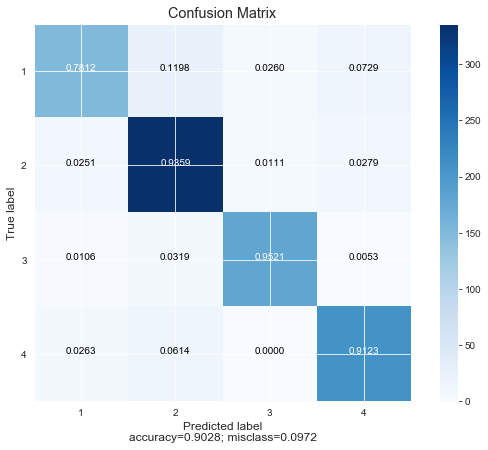

In [185]:
plot_confusion_matrix(cm           = (confusion), 
                      normalize    = True,
                      target_names = ['1', '2', '3', '4'],
                      title        = "Confusion Matrix")